# Humanoid Env

In [1]:
import gymnasium as gym
import numpy as np

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from collections import deque

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
# Crear el entorno Humanoid
env = gym.make("Humanoid-v4", render_mode='human')

In [4]:
print("Action Space {}". format(env.action_space))
print("State Space {}.". format(env.observation_space))

env.close()

Action Space Box(-0.4, 0.4, (17,), float32)
State Space Box(-inf, inf, (376,), float64).


## Q-learning & Double Q-learning

No es posible hacer Q-learning ni double q-learning debido a la dificultad del environment y su carácter continuo. Es necesario deep reinforcement learning, para establecer la policy o value function mediante una red neuronal.

## Deep Reinforcement Learning

### Deep Q-learning

In [16]:
# Building of DQN

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

input_shape = env.observation_space.shape
n_outputs = env.action_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [17]:
# Action selection policy

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        action = np.random.uniform(env.action_space.low, env.action_space.high, size=env.action_space.shape)
        return action
    else:
        Q_values = model.predict(state[np.newaxis])
        #print("q values", Q_values)
        return Q_values[0]

    
# Function to sample experiences

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones


# Function that use the DQN to play one step:

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, tr,info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info


#Function to train the DQN performing a training step:

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.matmul(all_Q_values, tf.cast(mask, tf.float32))
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [18]:
rewards = [] 
best_score = 0

# Replay memory

replay_memory = deque(maxlen=2000)

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.mean_squared_error

n_episodes = 1000

In [8]:
for episode in range(n_episodes):
    print("Episode:   ", episode)
    obs = env.reset() # reset the environment to a new random state
    obs=obs[0]
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            #print("done:   ", done)
            break
    rewards.append(step) # Not shown 
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode:    0
Episode: 0, Steps: 20, eps: 1.000Episode:    1
Episode: 1, Steps: 18, eps: 0.998Episode:    2
Episode: 2, Steps: 21, eps: 0.996Episode:    3
Episode: 3, Steps: 18, eps: 0.994Episode:    4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Episode: 4, Steps: 23, eps: 0.992Episode:    5
Episode: 5, Steps: 22, eps: 0.990Episode:    6
Episode: 6, Steps: 17, eps: 0.988Episode:    7
Episode: 7, Steps: 18, eps: 0.986Episode:    8
Episode: 8, Steps: 25, eps: 0.984Episode:    9
Episode: 9, Steps: 31, eps: 0.982Episode:    10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Episode: 10, Steps: 18, eps: 0.980Episode:    11
Episode: 11, Steps: 44, eps: 0.978Episode:    12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Episode: 12, Steps: 21, eps: 0.976Episode:    13
Episode: 13, Steps: 27, eps: 0.974Episode:    14
Episode: 14, Steps: 18, eps: 0.972Episode:    15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Episode: 15, Steps: 33, eps: 0.970Episode:    16
Episode: 16, Steps: 23, eps: 0.

c:\Users\juanl\anaconda3\envs\ML2\Lib\site-packages\tensorflow\python\ops\gen_array_ops.py:6566: RuntimeWarning: invalid value encountered in cast
  _result = pywrap_tfe.TFE_Py_FastPathExecute(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━

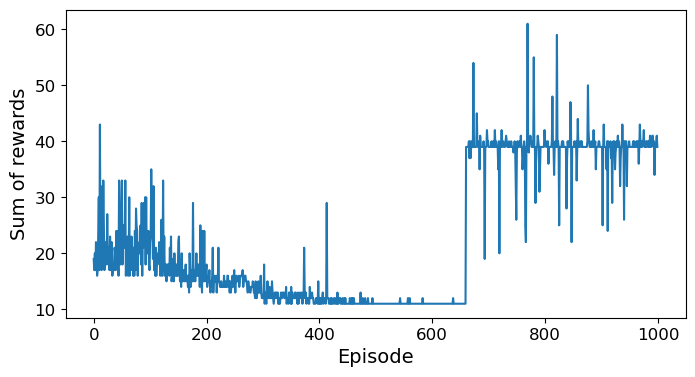

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

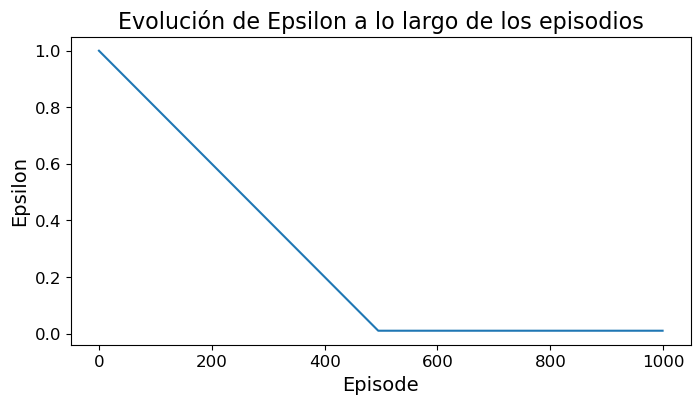

In [11]:
epsilons = [max(1 - episode / 500, 0.01) for episode in range(n_episodes)]

plt.figure(figsize=(8, 4))
plt.plot(epsilons)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Evolución de Epsilon a lo largo de los episodios", fontsize=16)
plt.show()

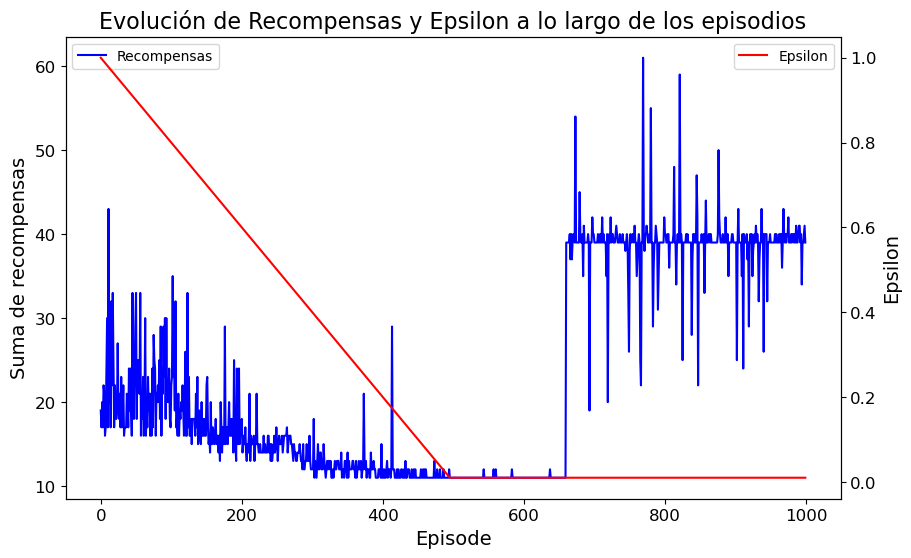

In [12]:
import matplotlib.pyplot as plt

epsilons = [max(1 - episode / 500, 0.01) for episode in range(n_episodes)]

plt.figure(figsize=(10, 6))

# Plot de las recompensas
plt.plot(rewards, label="Recompensas", color='blue')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Suma de recompensas", fontsize=14)
plt.legend(loc='upper left')

# Crear un eje secundario para el valor de epsilon
ax = plt.gca().twinx()
ax.plot(epsilons, label="Epsilon", color='red')
ax.set_ylabel("Epsilon", fontsize=14)
ax.legend(loc='upper right')

plt.title("Evolución de Recompensas y Epsilon a lo largo de los episodios", fontsize=16)
plt.show()


In [9]:
env.close()

In [19]:
model = keras.models.Sequential([
    keras.layers.Dense(128, activation="elu", input_shape=input_shape),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [20]:
rewards = [] 
best_score = 0

batch_size = 16
discount_rate = 0.98
optimizer = keras.optimizers.Adam(learning_rate=1e-1)
loss_fn = keras.losses.mean_squared_error
epsilon = 0.1

replay_memory = deque(maxlen=10000)

n_episodes = 1000

In [ ]:
for episode in range(n_episodes):
    print("Episode:   ", episode)
    obs = env.reset() # reset the environment to a new random state
    obs=obs[0]
    for step in range(200):

        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            #print("done:   ", done)
            break
    rewards.append(step) # Not shown 
    
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

### Double Deep Q Network

### Dueling Deep Q Network

### Policy Gradient Methods (Y todo lo que hay detrás)